In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import quandl

import cvxportfolio as cp

Download the problem data from Quandl. We select four liquid stocks, and the risk-free rate.

In [41]:
quandl.ApiConfig.api_key = 'MD5vrwzxyZbgJUcxdogL'



tickers    = ['AMZN', 'GOOGL', 'TSLA', 'NKE']
start_date = '2015-01-01'
end_date   = '2016-12-31'


returns_data = {
    ticker: quandl.get(dataset='WIKI/' + ticker, start_date=start_date, end_date=end_date)['Adj. Close'].pct_change()
    for ticker
    in tickers
}

returns = pd.DataFrame(data=returns_data)
returns[["USDOLLAR"]] = quandl.get('FRED/DTB3', start_date=start_date, end_date=end_date)/(250*100)
returns = returns.fillna(method='ffill').iloc[1:]

returns.tail()

,AMZN,GOOGL,NKE,TSLA,USDOLLAR
Date,,,,,
2016-12-23,-0.007503,-0.002322,-0.004411,0.023459,0.000020
2016-12-27,0.014213,0.002637,-0.011944,0.029015,0.000020
2016-12-28,0.000946,-0.006618,-0.005264,0.000957,0.000021
2016-12-29,-0.009040,-0.002101,0.000784,-0.023027,0.000018
2016-12-30,-0.019970,-0.012991,-0.004505,-0.004612,0.000020


We compute rolling estimates of the first and second moments of the returns using a window of 250 days. We shift them by one unit (so at every day we present the optimizer with only past data).

In [17]:
rere=(returns.rolling(window=250, min_periods=250).mean().shift(1))

rere.tail()

,AMZN,GOOGL,NKE,TSLA,USDOLLAR
Date,,,,,
2016-12-23,0.000683,0.000219,-0.000660,-0.000074,0.000012
2016-12-27,0.000542,0.000150,-0.000706,-0.000124,0.000013
2016-12-28,0.000627,0.000179,-0.000691,-0.000023,0.000013
2016-12-29,0.000707,0.000215,-0.000664,-0.000052,0.000013
2016-12-30,0.000901,0.000302,-0.000598,0.000133,0.000013


In [18]:
rere2= (returns
             .rolling(window=250, min_periods=250)
             .cov().unstack().shift(1).stack())
rere2.tail()

AMZN         GOOGL           NKE          TSLA  \
Date                                                                          
2016-12-30 AMZN      3.375380e-04  1.385427e-04  8.138472e-05  1.475612e-04   
           GOOGL     1.385427e-04  1.589377e-04  8.499972e-05  9.463344e-05   
           NKE       8.138472e-05  8.499972e-05  1.991368e-04  9.221405e-05   
           TSLA      1.475612e-04  9.463344e-05  9.221405e-05  5.817546e-04   
           USDOLLAR -2.618391e-09  1.995129e-09  1.694502e-09  6.616438e-09   

                         USDOLLAR  
Date                               
2016-12-30 AMZN     -2.618391e-09  
           GOOGL     1.995129e-09  
           NKE       1.694502e-09  
           TSLA      6.616438e-09  
           USDOLLAR  1.100055e-11

In [42]:
r_hat = (returns
         .rolling(window=250, min_periods=250)
         .mean()
         .shift(1)
         .dropna())

# https://stackoverflow.com/questions/13030245/how-to-shift-a-pandas-multiindex-series
Sigma_hat = (returns
             .rolling(window=250, min_periods=250)
             .cov()
             .unstack()
             .shift(1)
             .stack()
             .dropna())

r_hat.tail()

,AMZN,GOOGL,NKE,TSLA,USDOLLAR
Date,,,,,
2016-12-23,0.000683,0.000219,-0.000660,-0.000074,0.000012
2016-12-27,0.000542,0.000150,-0.000706,-0.000124,0.000013
2016-12-28,0.000627,0.000179,-0.000691,-0.000023,0.000013
2016-12-29,0.000707,0.000215,-0.000664,-0.000052,0.000013
2016-12-30,0.000901,0.000302,-0.000598,0.000133,0.000013


In [43]:
Sigma_hat[-10:]

AMZN         GOOGL           NKE          TSLA  \
Date                                                                          
2016-12-29 AMZN      3.508260e-04  1.441041e-04  8.496760e-05  1.628686e-04   
           GOOGL     1.441041e-04  1.612531e-04  8.647127e-05  1.011205e-04   
           NKE       8.496760e-05  8.647127e-05  2.000382e-04  9.652762e-05   
           TSLA      1.628686e-04  1.011205e-04  9.652762e-05  5.988515e-04   
           USDOLLAR -1.491325e-09  2.421500e-09  1.893623e-09  8.216710e-09   
2016-12-30 AMZN      3.375380e-04  1.385427e-04  8.138472e-05  1.475612e-04   
           GOOGL     1.385427e-04  1.589377e-04  8.499972e-05  9.463344e-05   
           NKE       8.138472e-05  8.499972e-05  1.991368e-04  9.221405e-05   
           TSLA      1.475612e-04  9.463344e-05  9.221405e-05  5.817546e-04   
           USDOLLAR -2.618391e-09  1.995129e-09  1.694502e-09  6.616438e-09   

                         USDOLLAR  
Date                               
2016-12-29 AMZN     -1.491325e-09  
           GOOGL     2.421500e-09  
           NKE       1.893623e-09  
           TSLA      8.216710e-09  
           USDOLLAR  1.092628e-11  
2016-12-30 AMZN     -2.618391e-09  
           GOOGL     1.995129e-09  
           NKE       1.694502e-09  
           TSLA      6.616438e-09  
           USDOLLAR  1.100055e-11

Here we define the transaction cost and holding cost model (sections 2.3 and 2.4 [of the paper](https://web.stanford.edu/~boyd/papers/cvx_portfolio.html)). The data can be expressed 
as 
- a scalar (like we're doing here), the same value for all assets and all time periods;
- a Pandas Series indexed by the asset names, for asset-specific values; 
- a Pandas DataFrame indexed by timestamps with asset names as columns, for values that vary by asset and in time.

In [44]:
tcost_model = cp.TcostModel(half_spread=10E-4)
hcost_model = cp.HcostModel(borrow_costs=1E-4)

We define the single period optimization policy (section 4 [of the paper](https://web.stanford.edu/~boyd/papers/cvx_portfolio.html)). 

In [46]:
return_forecast = cp.ReturnsForecast(returns=r_hat, delta=0)
risk_model      = cp.FullSigma(Sigma_hat)
gamma_risk      = 5.0
gamma_trade     = 1.0
gamma_hold      = 1.0
leverage_limit = cp.LeverageLimit(limit=3)

spo_policy = cp.SinglePeriodOpt(
    return_forecast = return_forecast, 
    costs           = [gamma_risk * risk_model, gamma_trade * tcost_model, gamma_hold * hcost_model],
    constraints     = [leverage_limit]
)

We run a backtest, which returns a result object. By calling its summary method we get some basic statistics.

In [54]:
market_sim = cp.MarketSimulator(
    yc_market_returns = returns,
    costs          = [tcost_model, hcost_model],
    cash_key       = 'USDOLLAR'
) 

init_portfolio = pd.Series(index=returns.columns, data=0.)
init_portfolio.USDOLLAR = 1000

result = market_sim.run_backtest(
    initial_portfolio = init_portfolio,
    start_time        = '2016-05-01',
    end_time          = '2016-12-31',  
    policy            = spo_policy
)

result.summary()

Number of periods                               169
Initial timestamp               2016-05-02 00:00:00
Final timestamp                 2016-12-30 00:00:00
Portfolio return (%)                          3.329
Excess return (%)                             2.988
Excess risk (%)                               5.795
Sharpe ratio                                  0.517
Max. drawdown                                 4.390
Turnover (%)                                 61.563
Average policy time (sec)                     0.025
Average simulator time (sec)                  0.013


The total value of the portfolio in time.

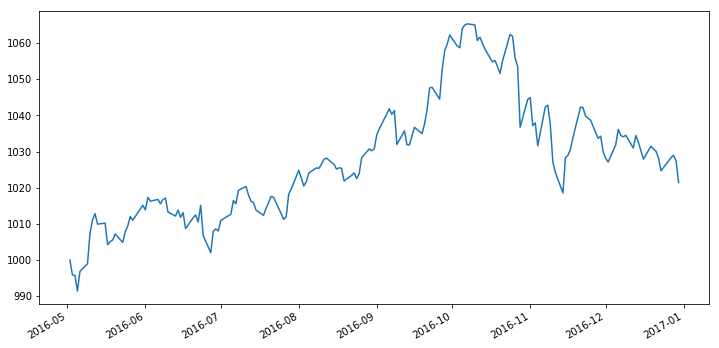

In [62]:
import matplotlib
matplotlib.pyplot.ion()

result.v.plot(figsize=(12,6))

The weights vector of the portfolio in time.

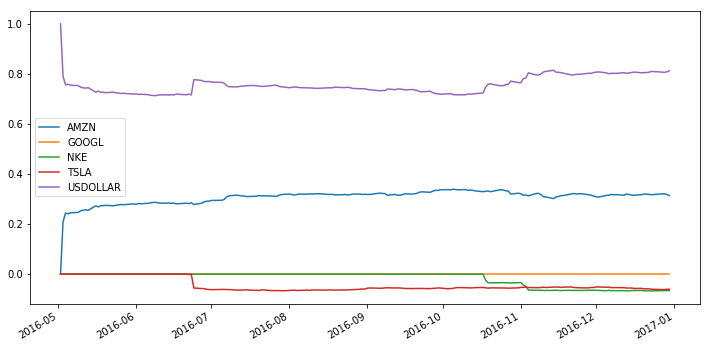

In [63]:
result.w.plot(figsize=(12,6))

### use dash to make interactive graph

In [67]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
import plotly.graph_objs as go

app = dash.Dash()


app.layout = html.Div([
    html.Div([

        html.Div([
            html.Label('stock kind'),
            dcc.Dropdown(
                id='stock kind',
                options=[{'label': i, 'value': i} for i in returns.columns],
                value='AMZN'
            ),
            html.Label('yaxis-type'),
            dcc.RadioItems(
                id='yaxis-type',
                options=[{'label': i, 'value': i} for i in ['Linear', 'Log']],
                value='Linear',
                labelStyle={'display': 'inline-block'}
            )
        ],
        style={'width': '48%', 'display': 'inline-block'}),

    ]),

    dcc.Graph(id='stock price pct change'),
    
    html.Div([

        html.Div([
            html.Label('portfolio'),
            dcc.Input(
                id='portfolio',
                type='number',
                value='100'
            )
        ],
        style={'width': '20%', 'display': 'inline-block'}),

        html.Div([
            html.Label('gamma'),
            dcc.Input(
                id='gamma',
                type='number',
                value='1'
            )
        ],style={'width': '20%', 'display': 'inline-block'}),
        
        html.Div([
            html.Label('Result'),
            dcc.Dropdown(
                id='w or v',
                options=[{'label': i, 'value': i} for i in ['w', 'v']],
                value='w'
            )
        ],style={'width': '20%', 'display': 'inline-block'})
    ]),

    dcc.Graph(id='result'),
    
])

@app.callback(
    dash.dependencies.Output('stock price pct change', 'figure'),
    [dash.dependencies.Input('stock kind', 'value'),
     dash.dependencies.Input('yaxis-type', 'value')])
def update_graph(xaxis_column_name,
                 yaxis_type
                 ):
    

    return {
        'data': [go.Scatter(
            x=returns[xaxis_column_name].index,
            y=returns[xaxis_column_name].values,

            mode='lines'
            
        )],
        'layout': go.Layout(
            
            yaxis={
                'title': 'stock price pct change',
                'type': 'linear' if yaxis_type == 'Linear' else 'log'
            },
            margin={'l': 40, 'b': 40, 't': 10, 'r': 0},
            hovermode='closest'
        )
    }



@app.callback(
    dash.dependencies.Output('result', 'figure'),
    [dash.dependencies.Input('portfolio', 'value'),
     dash.dependencies.Input('gamma', 'value'),
     dash.dependencies.Input('w or v', 'value'),])
def update_vector_graph(portfoliov, gamma, kind
                 ):
    
    return_forecast = cp.ReturnsForecast(returns=r_hat, delta=0)
    risk_model      = cp.FullSigma(Sigma_hat)
    gamma_risk      = 5.0
    gamma_trade     = float(gamma)
    gamma_hold      = 1.0
    leverage_limit = cp.LeverageLimit(limit=3)

    spo_policy = cp.SinglePeriodOpt(
        return_forecast = return_forecast, 
        costs           = [gamma_risk * risk_model, gamma_trade * tcost_model, gamma_hold * hcost_model],
        constraints     = [leverage_limit]
    )

    
    market_sim = cp.MarketSimulator(
    yc_market_returns = returns,
    costs          = [tcost_model, hcost_model],
    cash_key       = 'USDOLLAR'
    ) 

    init_portfolio = pd.Series(index=returns.columns, data=0.)
    init_portfolio.USDOLLAR = portfoliov

    result = market_sim.run_backtest(
        initial_portfolio = init_portfolio,
        start_time        = '2016-05-01',
        end_time          = '2016-12-31',  
        policy            = spo_policy
    )
    
    if kind == 'w':
        return {
            'data': [
                go.Scatter(
                x=result.w[i].index,
                y=result.w[i].values,
                text = i,
                name = i,
                mode='lines'

            ) for i in returns.columns],
            'layout': go.Layout(


                margin={'l': 40, 'b': 40, 't': 10, 'r': 0},
                hovermode='closest'
            )
        }
    elif kind == 'v':
        return {
        'data': [go.Scatter(
            x=result.v.index,
            y=result.v.values,

            mode='lines'
            
        )],
        'layout': go.Layout(
            
            
            margin={'l': 40, 'b': 40, 't': 10, 'r': 0},
            hovermode='closest'
        )
    }
    

if __name__ == '__main__':
    app.run_server()

[2018-04-23 20:10:23,219] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/flask/app.py", line 1982, in wsgi_app
    response = self.full_dispatch_request()
  File "/anaconda3/lib/python3.6/site-packages/flask/app.py", line 1614, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/anaconda3/lib/python3.6/site-packages/flask/app.py", line 1517, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/anaconda3/lib/python3.6/site-packages/flask/_compat.py", line 33, in reraise
    raise value
  File "/anaconda3/lib/python3.6/site-packages/flask/app.py", line 1612, in full_dispatch_request
    rv = self.dispatch_request()
  File "/anaconda3/lib/python3.6/site-packages/flask/app.py", line 1598, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "/anaconda3/lib/python3.6/site-packages/dash/dash.py", line 556, in dispatch
    ret

#### use tab

In [23]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
import plotly.graph_objs as go
from loremipsum import get_sentences

app = dash.Dash()

app.layout = html.Div([
        html.Div(
            dcc.Tabs(
                tabs=[
                    {'label': 'Daily percentage change', 'value': 1},
                    {'label': 'Show vector', 'value': 2},
                    {'label': 'Show weight', 'value': 3},
                    {'label': 'TBD', 'value': 4},
                ],
                value=1,
                id='tabs',
                vertical=True,
                style={
                    'height': '100vh',
                    'borderRight': 'thin lightgrey solid',
                    'textAlign': 'left'
                }
            ),
            style={'width': '20%', 'float': 'left'}
        ),
        html.Div(
            html.Div(id='tab-output'),
            style={'width': '80%', 'float': 'right'}
        )
    ], style={
        'fontFamily': 'Sans-Serif',
        'margin-left': 'auto',
        'margin-right': 'auto',
    })


@app.callback(dash.dependencies.Output('tab-output', 'children'), [dash.dependencies.Input('tabs', 'value')])
def display_content(value):

    
    return {1: html.Div([ 
                html.Div([

                    html.Div([
                        html.Label('stock kind'),
                        dcc.Dropdown(
                            id='stock kind',
                            options=[{'label': i, 'value': i} for i in returns.columns],
                            value='AMZN'
                        ),
                        html.Label('xaxis-type'),
                        dcc.RadioItems(
                            id='xaxis-type',
                            options=[{'label': i, 'value': i} for i in ['Linear', 'Log']],
                            value='Linear',
                            labelStyle={'display': 'inline-block'}
                        )
                    ],
                    style={'width': '48%', 'display': 'inline-block'}),

                    html.Div([
                        dcc.Dropdown(
                            id='yaxis-column',
                            options=[{'label': i, 'value': i} for i in returns.columns],
                            value='pct change'
                        ),
                        dcc.RadioItems(
                            id='yaxis-type',
                            options=[{'label': i, 'value': i} for i in ['Linear', 'Log']],
                            value='Linear',
                            labelStyle={'display': 'inline-block'}
                        )
                    ],style={'width': '48%', 'float': 'right', 'display': 'inline-block'})
                ]),

                dcc.Graph(id='stock price pct change')]) ,
            
            2: html.Div([ 
                html.Div([

                    html.Div([
                        html.Label('portfolio'),
                        dcc.Input(
                            id='portfolio',
                            type='number',
                            value='100'
                        )
                    ],
                    style={'width': '48%', 'display': 'inline-block'}),

                    html.Div([
                        html.Label('gamma'),
                        dcc.Input(
                            id='gamma',
                            type='number',
                            value='1'
                        )
                    ],style={'width': '48%', 'float': 'right', 'display': 'inline-block'})
                ]),

                dcc.Graph(id='vector')]),
            
            3: html.Div([ 
                html.Div([

                    html.Div([
                        html.Label('portfolio'),
                        dcc.Input(
                            id='portfolio',
                            type='number',
                            value='100'
                        )
                    ],
                    style={'width': '48%', 'display': 'inline-block'}),

                    html.Div([
                        html.Label('gamma'),
                        dcc.Input(
                            id='gamma',
                            type='number',
                            value='1'
                        )
                    ],style={'width': '48%', 'float': 'right', 'display': 'inline-block'})
                ]),

                dcc.Graph(id='vector')])
           }.get(value,'default')

@app.callback(
    dash.dependencies.Output('stock price pct change', 'figure'),
    [dash.dependencies.Input('stock kind', 'value'),
     dash.dependencies.Input('yaxis-column', 'value'),
     dash.dependencies.Input('xaxis-type', 'value'),
     dash.dependencies.Input('yaxis-type', 'value')])
def update_graph(xaxis_column_name, yaxis_column_name,
                 xaxis_type, yaxis_type
                 ):
    

    return {
        'data': [go.Scatter(
            x=returns[xaxis_column_name].index,
            y=returns[xaxis_column_name].values,

            mode='lines'
            
        )],
        'layout': go.Layout(
            
            yaxis={
                'title': yaxis_column_name,
                'type': 'linear' if yaxis_type == 'Linear' else 'log'
            },
            margin={'l': 40, 'b': 40, 't': 10, 'r': 0},
            hovermode='closest'
        )
    }

@app.callback(
    dash.dependencies.Output('vector', 'figure'),
    [dash.dependencies.Input('portfolio', 'value'),
     dash.dependencies.Input('gamma', 'value')])
def update_vector_graph(portfolio, gamma
                 ):
    

    return {
        'data': [go.Scatter(
            x=result.v.index,
            y=result.v.values,

            mode='lines'
            
        )],
        'layout': go.Layout(
            
            
            margin={'l': 40, 'b': 40, 't': 10, 'r': 0},
            hovermode='closest'
        )
    }

@app.callback(
    dash.dependencies.Output('weight', 'figure'),
    [dash.dependencies.Input('portfolio', 'value'),
     dash.dependencies.Input('gamma', 'value')])
def update_vector_graph(portfolio, gamma
                 ):
    
    gamma_risk      = 5.0
    gamma_trade     = float(gamma)
    gamma_hold      = 1.0
    
    leverage_limit = cp.LeverageLimit(limit=3)

    spo_policy = cp.SinglePeriodOpt(
        return_forecast = return_forecast, 
        costs           = [gamma_risk * risk_model, gamma_trade * tcost_model, gamma_hold * hcost_model],
        constraints     = [leverage_limit]
    )
    
    market_sim = cp.MarketSimulator(
    yc_market_returns = returns,
    costs          = [tcost_model, hcost_model],
    cash_key       = 'USDOLLAR'
    ) 

    init_portfolio = pd.Series(index=returns.columns, data=0.)
    init_portfolio.USDOLLAR = portfolio

    result = market_sim.run_backtest(
        initial_portfolio = init_portfolio,
        start_time        = '2015-05-01',
        end_time          = '2016-12-31',  
        policy            = spo_policy
    )
    
    return {
        'data': [
            go.Scatter(
            x=result.w[i].index,
            y=result.w[i].values,
            text = i,
            mode='lines'
            
        ) for i in returns.columns],
        'layout': go.Layout(
            
            
            margin={'l': 40, 'b': 40, 't': 10, 'r': 0},
            hovermode='closest'
        )
    }

if __name__ == '__main__':
    app.run_server(debug=True)

NonExistantIdException: 
Attempting to assign a callback to the
component with the id "stock price pct change" but no
components with id "stock price pct change" exist in the
app's layout.


Here is a list of IDs in layout:
['tabs', 'tab-output']


If you are assigning callbacks to components
that are generated by other callbacks
(and therefore not in the initial layout), then
you can suppress this exception by setting
`app.config['suppress_callback_exceptions']=True`.
